In [1]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import os 
import sys 
import utils
%matplotlib inline

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

---

# Hyperparameter

In [2]:
SHUFFLE_BUFFER = 4000
BATCH_SIZE = 16
lr = 0.00001
opt = tf.keras.optimizers.Adam(lr)
tfrecords_read_dir = '/home/kevinteng/Desktop/BRATS_stack/tfrecords/'

---

# Helper Functions

In [3]:
def dicesq(y_true, y_pred):
    '''
    Modified dice coefficient as refer to: https://arxiv.org/abs/1606.04797
    :param y_true: Ground truth
    :param y_pred: Prediction from the model
    :return: Modified dice coefficient
    '''
    nmr = 2*tf.reduce_sum(y_true*y_pred)
    dnmr = tf.reduce_sum(y_true**2) + tf.reduce_sum(y_pred**2) + tf.keras.backend.epsilon()
    return (nmr / dnmr)

def dicesq_loss(y_true, y_pred):
    '''
    Modified dice coefficient loss
    :param y_true: Ground truth
    :param y_pred: Prediction from the model
    '''
    return 1- dicesq(y_true, y_pred)

def dice_coef(y_true, y_pred):
    '''
    Dice coefficient for tensorflow
    '''
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + tf.keras.backend.epsilon()) / \
(tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + tf.keras.backend.epsilon())

def dice_coef_loss(y_true, y_pred):
    '''
    Dice coefficient loss for IOU
    '''
    return 1-dice_coef(y_true, y_pred)

def plot_comparison(input_img, caption, n_row=1, n_col=2, figsize=(10, 10), cmap = 'gray'):
    '''
    Plot comparison of multiple image but only in column wise!
    :param input_img: Input image list
    :param caption: Input caption list
    :param IMG_SIZE: Image size
    :param n_row: Number of row is 1 by DEFAULT
    :param n_col: Number of columns
    :param figsize: Figure size during plotting
    :return: Plot of (n_row, n_col)
    '''
    print()
    assert len(caption) == len(input_img), "Caption length and input image length does not match"
    assert len(input_img) == n_col, "Error of input images or number of columns!"

    fig, axes = plt.subplots(n_row, n_col, figsize=figsize)
    fig.subplots_adjust(hspace=0.4, wspace=0.4, right=0.7)

    for i in range(n_col):
        axes[i].imshow(np.squeeze(input_img[i]), cmap= cmap)
        axes[i].set_xlabel(caption[i])
        axes[i].set_xticks([])
        axes[i].set_yticks([])

    plt.tight_layout()
    plt.show()

----

# Model

In [4]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization

def conv_block(x_in, filters, batch_norm = False, kernel_size=(3,3)):
    x = Conv2D(filters, kernel_size, padding='same')(x_in)
    if batch_norm==True:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    if batch_norm==True:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def conv_2d(x_in, filters, batch_norm = False, kernel_size=(3,3),acti ='relu'):
    x = Conv2D(filters, kernel_size, padding='same')(x_in)
    if batch_norm==True:
        x=BatchNormalization()(x)
    x= Activation(acti)(x)
    return x
    
def pool(x_in, pool_size=(2, 2), type='Max'):
    if type=='Max':
        p = MaxPooling2D(pool_size)(x_in)
    return p

def up(x_in, filters, merge, batch_norm = False, size=(2,2)):
    u = UpSampling2D(size)(x_in)
    conv = conv_2d(u, filters, batch_norm)
    concat = tf.concat([merge, conv],axis=-1)
    return concat
    
def Unet_model(input_layer):
    #downsampling
    conv1 = conv_block(input_layer, filters=64)
    pool1 = pool(conv1)
    
    conv2 = conv_block(pool1, filters=128)
    pool2 = pool(conv2)
    
    conv3 = conv_block(pool2, filters=256)
    pool3 = pool(conv3)
    
    conv4 = conv_block(pool3, filters=512)
    pool4 = pool(conv4)
    
    conv5 = conv_block(pool4, filters=1024)
    
    #upsampling
    up1 = up(conv5,filters=512, merge=conv4)
    conv6 = conv_block(up1, filters=512)
    
    up2 = up(conv6, filters=256, merge=conv3)
    conv7 = conv_block(up2, filters=256)
    
    up3 = up(conv7, filters=128, merge=conv2)
    conv8 = conv_block(up3, filters=128)
    
    up4 = up(conv8, filters=64, merge=conv1)
    conv9 = conv_block(up4, filters=64)
    
    #on paper filters = 2
    output_layer = conv_2d(conv9, filters=1, kernel_size=(1,1), acti='sigmoid')
    
    return output_layer

In [5]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input

input_layer = Input(shape=(240,240,1))
Unet = Model(input_layer, Unet_model(input_layer))

In [6]:
#to do..Sensitivity
@tf.function
def train_fn(image, label):
    with tf.GradientTape() as tape:
        model_output = Unet(image)
        loss = dice_coef_loss(label, model_output)
    gradients = tape.gradient(loss, Unet.trainable_variables)
    opt.apply_gradients(zip(gradients, Unet.trainable_variables))
    
    return model_output, loss, gradients

Epochs  1

HGG_lbl_complete_tumor_HGG_training_MR_Flair.tfrecords




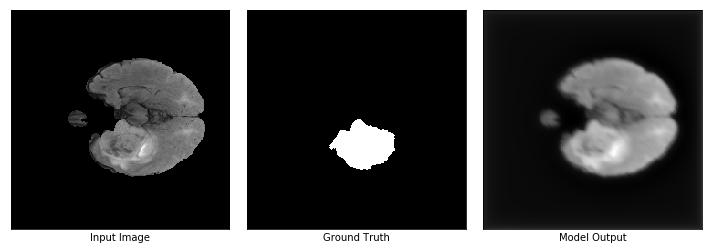

Steps: 100, Loss:0.9645718336105347, Dice Coefficient: 0.03542816638946533
Gradient min:-0.001988558331504464, max:0.0011523758294060826



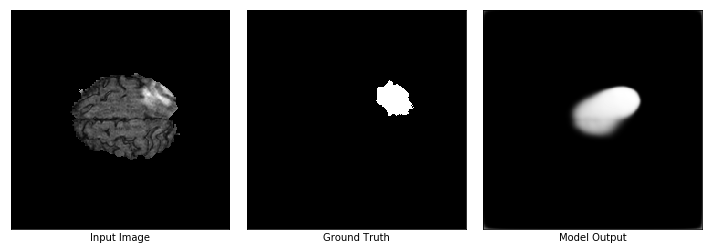

Steps: 200, Loss:0.7064236402511597, Dice Coefficient: 0.29357635974884033
Gradient min:-0.017267923802137375, max:0.034573689103126526



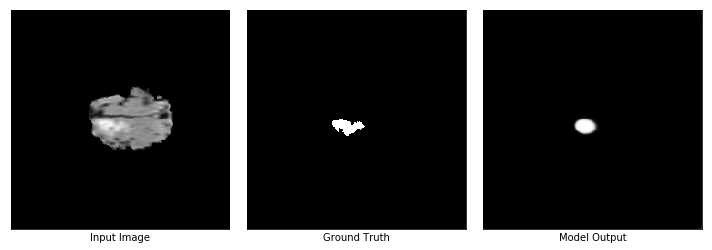

Steps: 300, Loss:0.6451185941696167, Dice Coefficient: 0.3548814058303833
Gradient min:-0.24315005540847778, max:0.14808149635791779



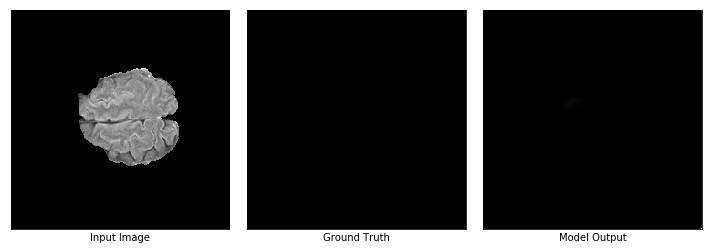

Steps: 400, Loss:0.3639931082725525, Dice Coefficient: 0.6360068917274475
Gradient min:-0.051167845726013184, max:0.019135652109980583



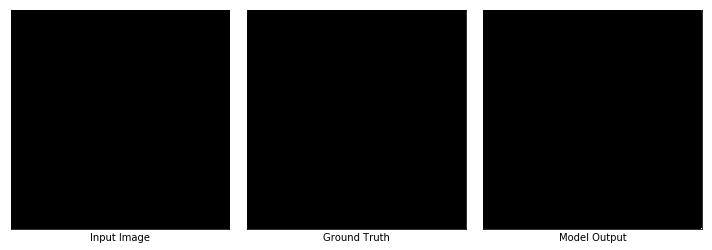

Steps: 500, Loss:0.5015528202056885, Dice Coefficient: 0.4984471797943115
Gradient min:-0.14060233533382416, max:0.07025197893381119



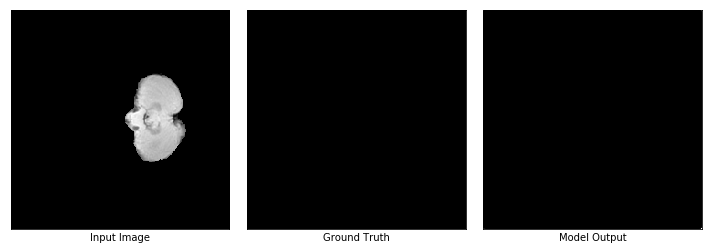

Steps: 600, Loss:0.462135374546051, Dice Coefficient: 0.537864625453949
Gradient min:-0.1311347931623459, max:0.06359060853719711



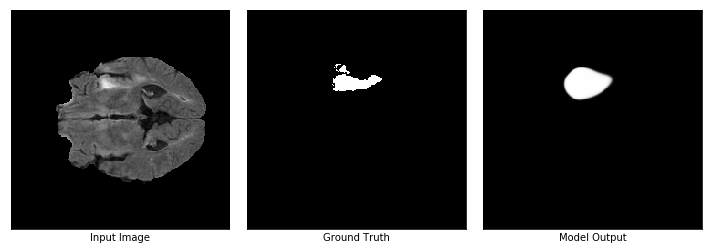

Steps: 700, Loss:0.3006989359855652, Dice Coefficient: 0.6993010640144348
Gradient min:-0.07475098222494125, max:0.12059436738491058



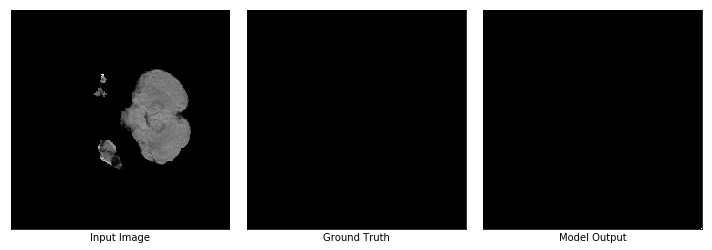

Steps: 800, Loss:0.37982994318008423, Dice Coefficient: 0.6201700568199158
Gradient min:-0.10017954558134079, max:0.05158506706357002



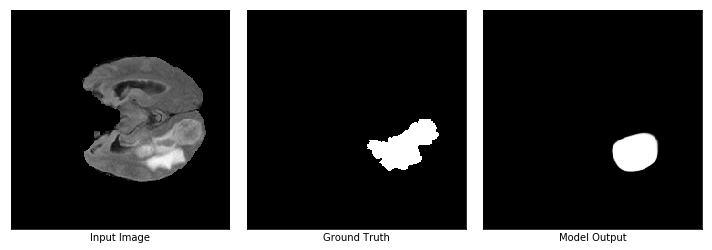

Steps: 900, Loss:0.3317829370498657, Dice Coefficient: 0.6682170629501343
Gradient min:-0.0685812458395958, max:0.04900951683521271



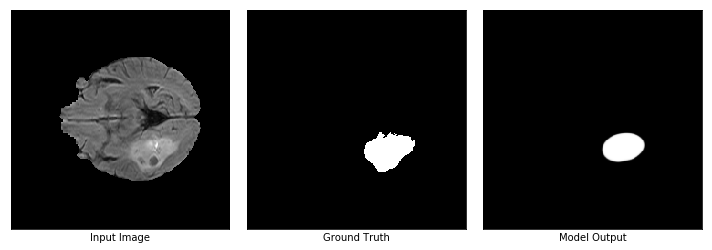

Steps: 1000, Loss:0.29014456272125244, Dice Coefficient: 0.7098554372787476
Gradient min:-0.10336952656507492, max:0.0601818710565567



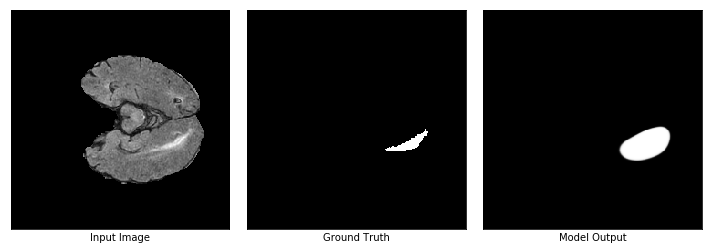

Steps: 1100, Loss:0.21166670322418213, Dice Coefficient: 0.7883332967758179
Gradient min:-0.030389590188860893, max:0.0451945886015892



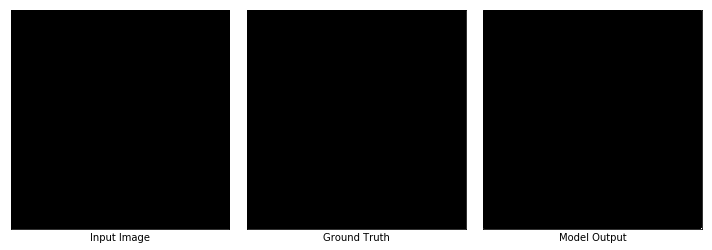

Steps: 1200, Loss:0.17147183418273926, Dice Coefficient: 0.8285281658172607
Gradient min:-0.13674531877040863, max:0.08917020261287689



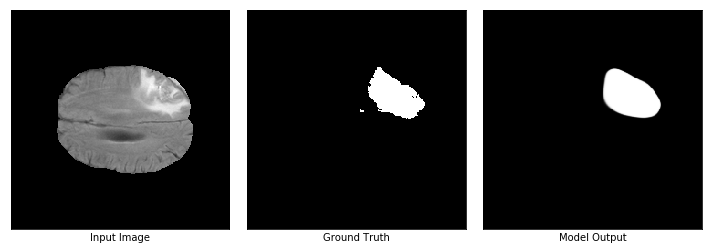

Steps: 1300, Loss:0.24002206325531006, Dice Coefficient: 0.7599779367446899
Gradient min:-0.045297857373952866, max:0.07176964730024338



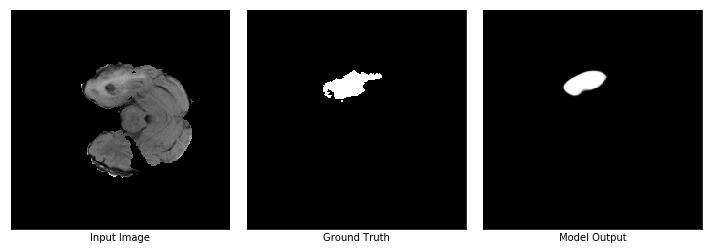

Steps: 1400, Loss:0.21497488021850586, Dice Coefficient: 0.7850251197814941
Gradient min:-0.06969994306564331, max:0.04432939738035202



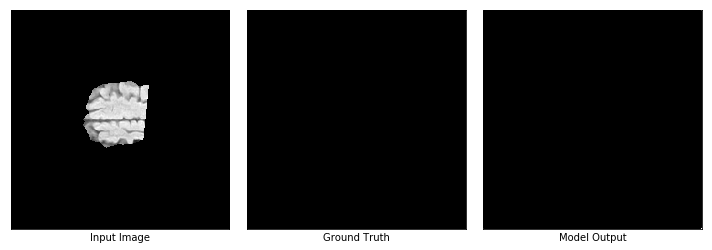

Steps: 1500, Loss:0.25537312030792236, Dice Coefficient: 0.7446268796920776
Gradient min:-0.01408056728541851, max:0.02141052857041359



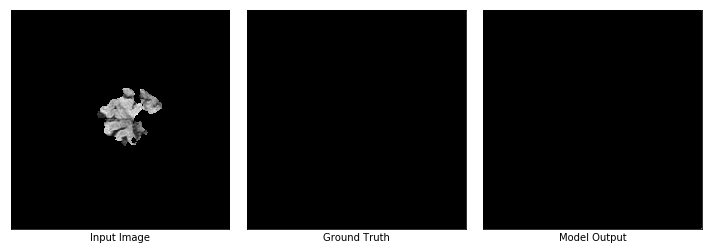

Steps: 1600, Loss:0.18366074562072754, Dice Coefficient: 0.8163392543792725
Gradient min:-0.018175087869167328, max:0.016030486673116684



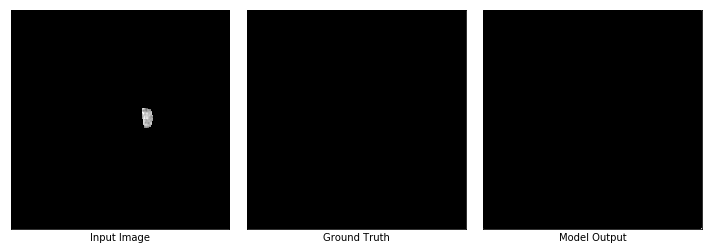

Steps: 1700, Loss:0.24937480688095093, Dice Coefficient: 0.7506251931190491
Gradient min:-0.1693267673254013, max:0.11401859670877457



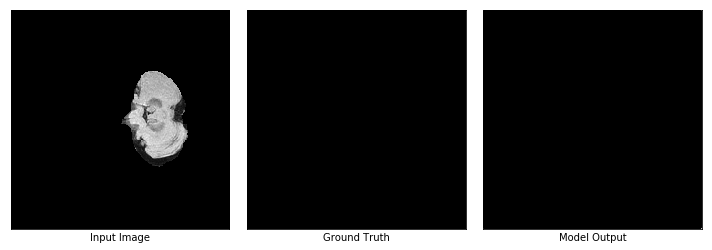

Steps: 1800, Loss:0.23601239919662476, Dice Coefficient: 0.7639876008033752
Gradient min:-0.13480307161808014, max:0.16548939049243927



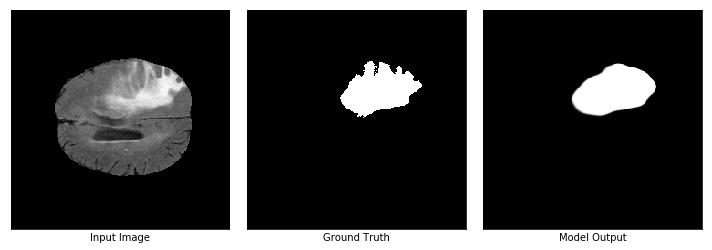

Steps: 1900, Loss:0.17260676622390747, Dice Coefficient: 0.8273932337760925
Gradient min:-0.03563837334513664, max:0.04155212268233299



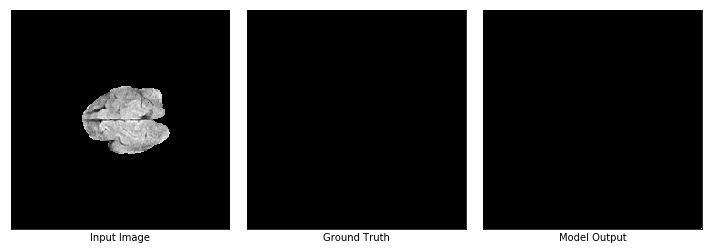

Steps: 2000, Loss:0.18664753437042236, Dice Coefficient: 0.8133524656295776
Gradient min:-0.06684067845344543, max:0.03486400097608566



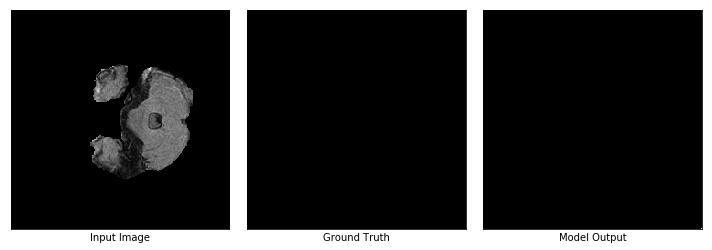

Steps: 2100, Loss:0.2153872847557068, Dice Coefficient: 0.7846127152442932
Gradient min:-0.10552150011062622, max:0.09451793134212494

Average Dice Coefficient: 0.6489390730857849
HGG_lbl_complete_tumor_HGG_training_MR_T1.tfrecords




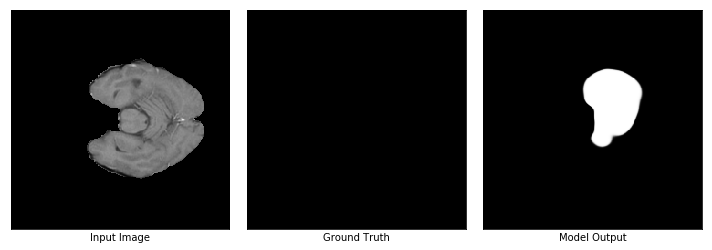

Steps: 2200, Loss:0.9144037365913391, Dice Coefficient: 0.08559626340866089
Gradient min:-0.009951876476407051, max:0.009175454266369343



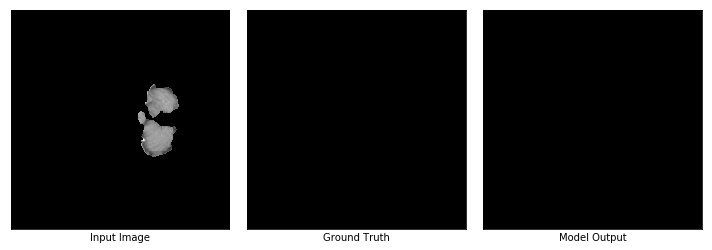

Steps: 2300, Loss:0.8494207859039307, Dice Coefficient: 0.15057921409606934
Gradient min:-0.007016464602202177, max:0.004628516733646393



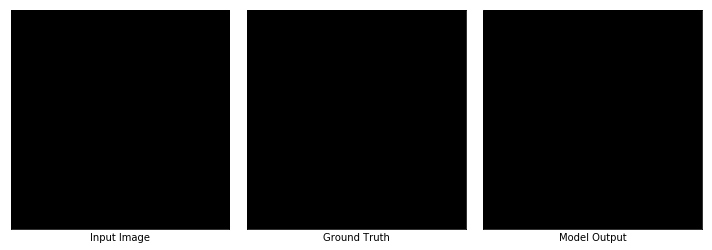

Steps: 2400, Loss:0.7749018669128418, Dice Coefficient: 0.2250981330871582
Gradient min:-0.003800226142629981, max:0.0024605263024568558



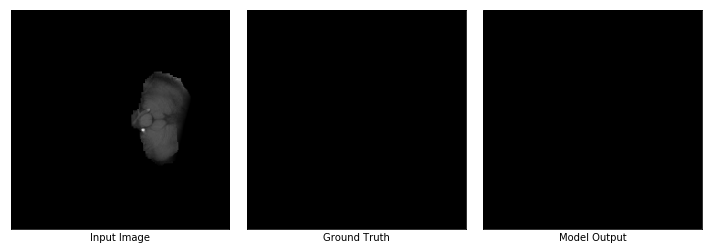

Steps: 2500, Loss:0.7369206547737122, Dice Coefficient: 0.26307934522628784
Gradient min:-0.012454118579626083, max:0.015694111585617065



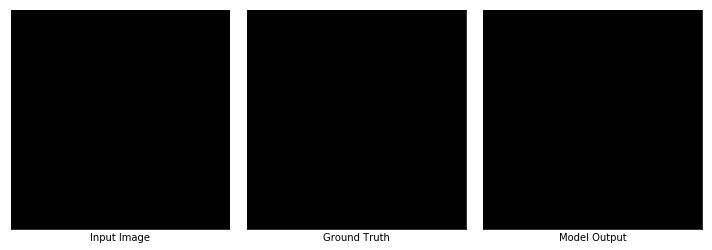

Steps: 2600, Loss:0.7853204011917114, Dice Coefficient: 0.21467959880828857
Gradient min:-0.010253436863422394, max:0.0076364800333976746



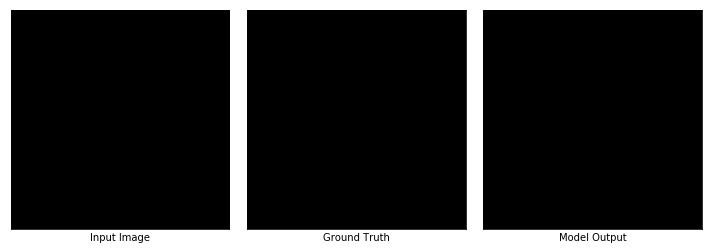

Steps: 2700, Loss:0.7247958183288574, Dice Coefficient: 0.2752041816711426
Gradient min:-0.009170080535113811, max:0.0045571280643343925



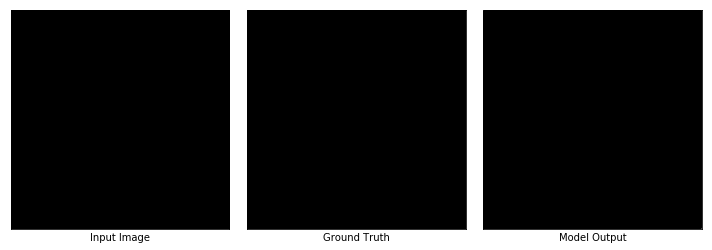

Steps: 2800, Loss:0.7887325286865234, Dice Coefficient: 0.21126747131347656
Gradient min:-0.014253475703299046, max:0.014558893628418446



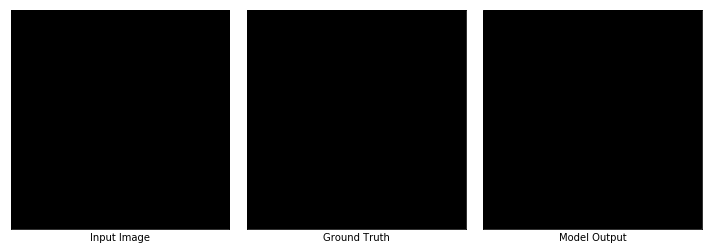

Steps: 2900, Loss:0.7841478586196899, Dice Coefficient: 0.21585214138031006
Gradient min:-0.011111612431704998, max:0.011906217783689499



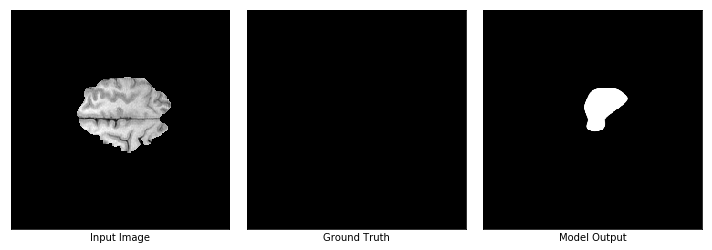

Steps: 3000, Loss:0.6523619294166565, Dice Coefficient: 0.3476380705833435
Gradient min:-0.007109933067113161, max:0.00589234521612525



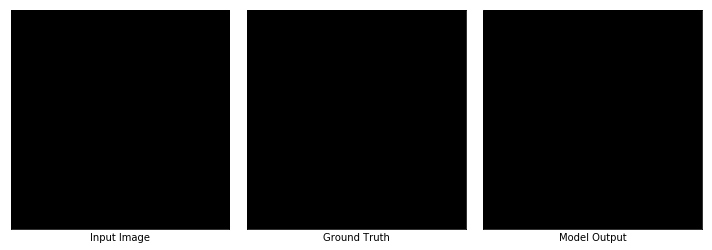

Steps: 3100, Loss:0.783376157283783, Dice Coefficient: 0.21662384271621704
Gradient min:-0.009291949681937695, max:0.02011764422059059



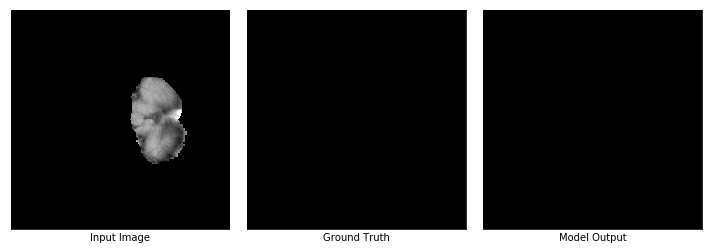

Steps: 3200, Loss:0.8131064176559448, Dice Coefficient: 0.18689358234405518
Gradient min:-0.03864419087767601, max:0.05262865126132965



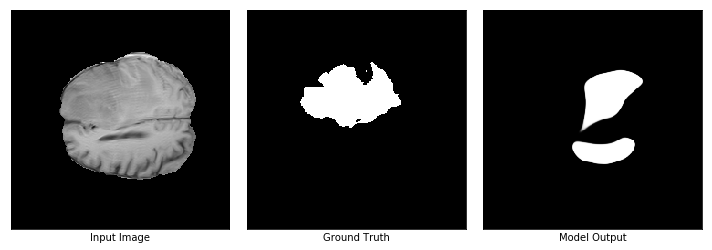

Steps: 3300, Loss:0.7931380271911621, Dice Coefficient: 0.2068619728088379
Gradient min:-0.018006356433033943, max:0.022987637668848038



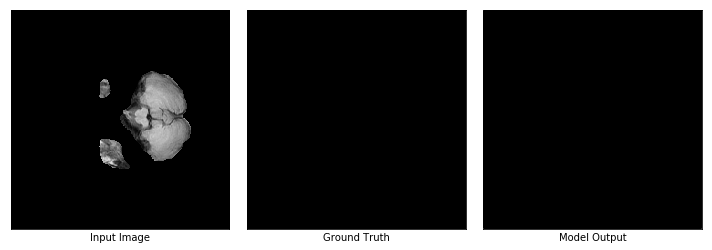

Steps: 3400, Loss:0.8174774646759033, Dice Coefficient: 0.18252253532409668
Gradient min:-0.06060856208205223, max:0.03674549609422684



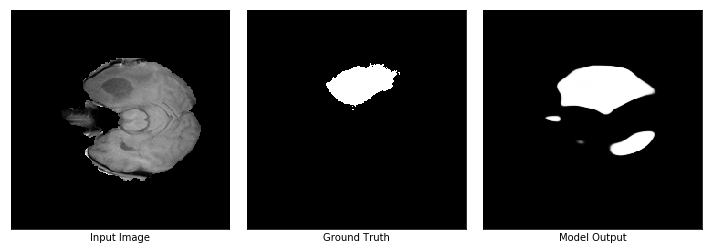

Steps: 3500, Loss:0.5253963470458984, Dice Coefficient: 0.47460365295410156
Gradient min:-0.03224646672606468, max:0.03924813121557236



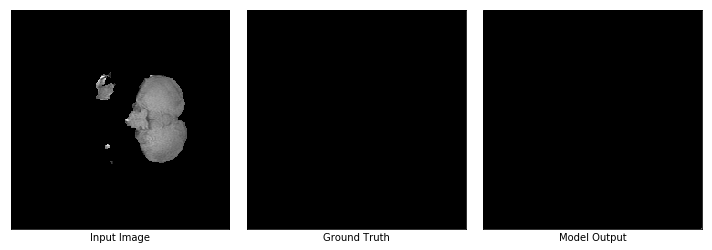

Steps: 3600, Loss:0.5109468102455139, Dice Coefficient: 0.4890531897544861
Gradient min:-0.06586484611034393, max:0.07272708415985107



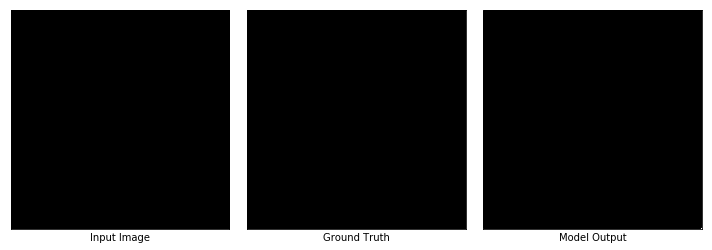

Steps: 3700, Loss:0.7479627132415771, Dice Coefficient: 0.25203728675842285
Gradient min:-0.05373094603419304, max:0.09503665566444397



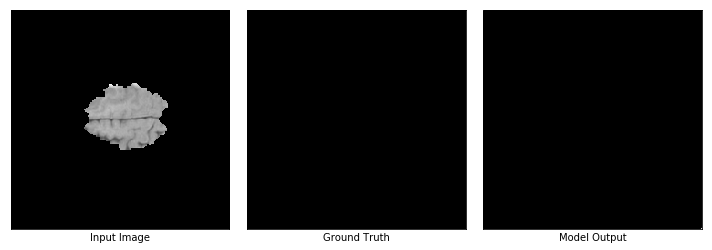

Steps: 3800, Loss:0.9055172204971313, Dice Coefficient: 0.09448277950286865
Gradient min:-0.041089095175266266, max:0.05005302652716637



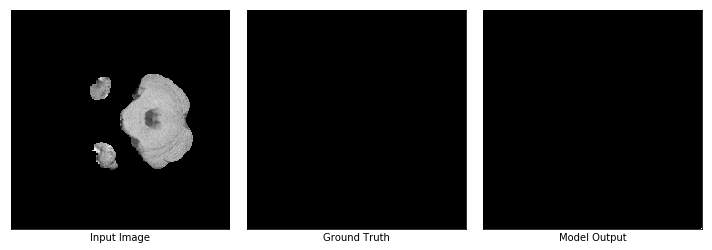

Steps: 3900, Loss:0.5136188268661499, Dice Coefficient: 0.4863811731338501
Gradient min:-0.039209336042404175, max:0.07336387038230896



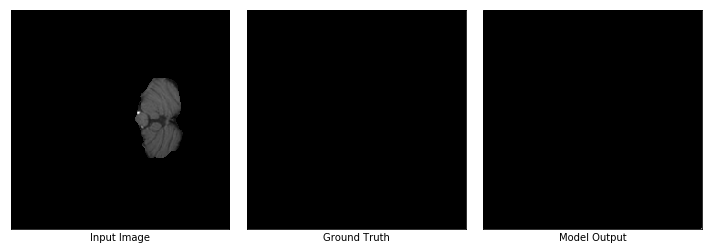

Steps: 4000, Loss:0.38213104009628296, Dice Coefficient: 0.617868959903717
Gradient min:-0.06418422609567642, max:0.1127113550901413



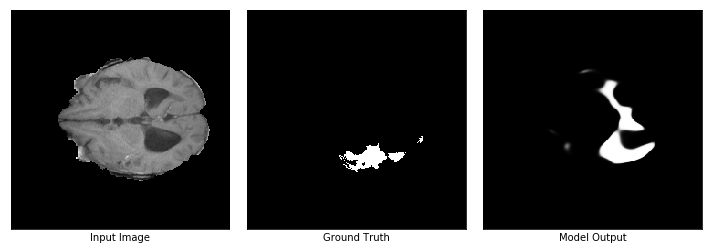

Steps: 4100, Loss:0.44329434633255005, Dice Coefficient: 0.55670565366745
Gradient min:-0.11643514037132263, max:0.11967148631811142



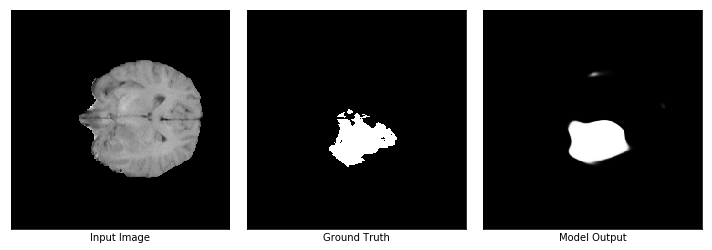

Steps: 4200, Loss:0.40654635429382324, Dice Coefficient: 0.5934536457061768
Gradient min:-0.0693107321858406, max:0.10032887756824493

Average Dice Coefficient: 0.4742811918258667
HGG_lbl_complete_tumor_HGG_training_MR_T1c.tfrecords




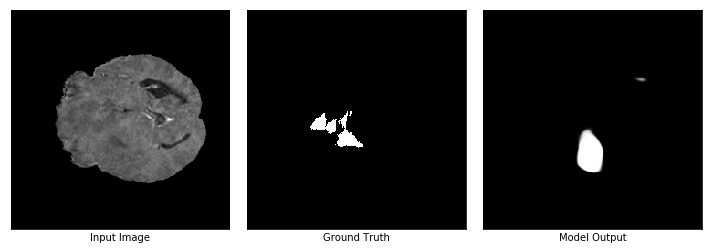

Steps: 4300, Loss:0.5323876738548279, Dice Coefficient: 0.4676123261451721
Gradient min:-0.09303018450737, max:0.1457357108592987



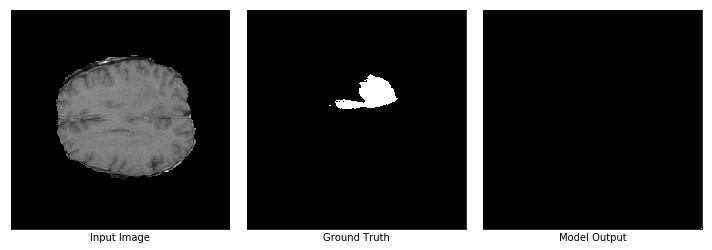

Steps: 4400, Loss:0.47840601205825806, Dice Coefficient: 0.5215939879417419
Gradient min:-0.056772857904434204, max:0.06369658559560776



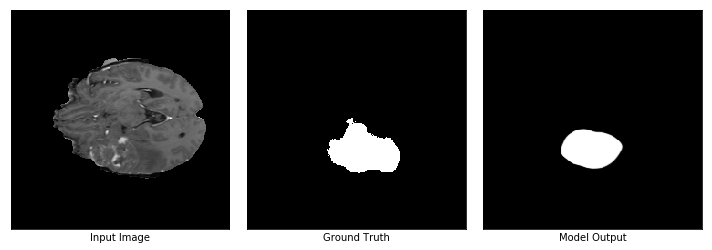

Steps: 4500, Loss:0.5621694326400757, Dice Coefficient: 0.4378305673599243
Gradient min:-0.37978994846343994, max:0.5770754218101501



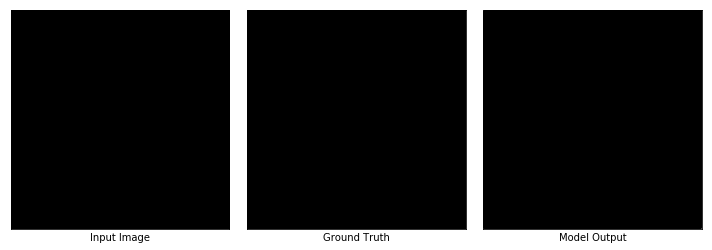

Steps: 4600, Loss:0.29832154512405396, Dice Coefficient: 0.701678454875946
Gradient min:-0.03660483658313751, max:0.051532529294490814



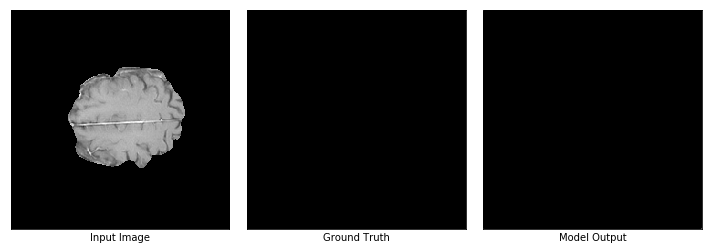

Steps: 4700, Loss:0.3001832365989685, Dice Coefficient: 0.6998167634010315
Gradient min:-0.1258053183555603, max:0.09579594433307648



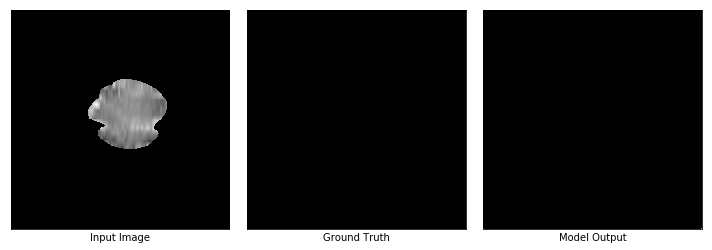

Steps: 4800, Loss:0.6226065158843994, Dice Coefficient: 0.3773934841156006
Gradient min:-0.26765021681785583, max:0.3268930912017822



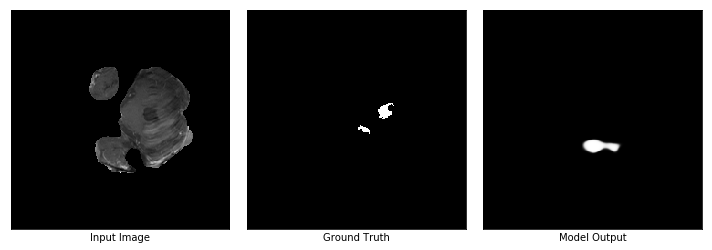

Steps: 4900, Loss:0.5598160028457642, Dice Coefficient: 0.44018399715423584
Gradient min:-0.30798834562301636, max:0.2109280377626419



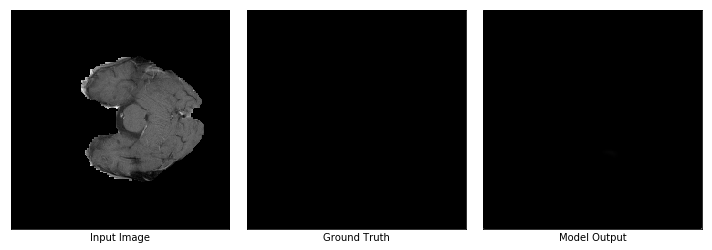

Steps: 5000, Loss:0.5860991477966309, Dice Coefficient: 0.41390085220336914
Gradient min:-0.1209404394030571, max:0.15282267332077026



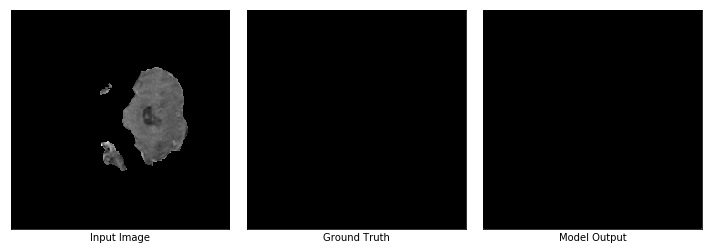

Steps: 5100, Loss:0.4371882677078247, Dice Coefficient: 0.5628117322921753
Gradient min:-0.14913810789585114, max:0.11118967086076736



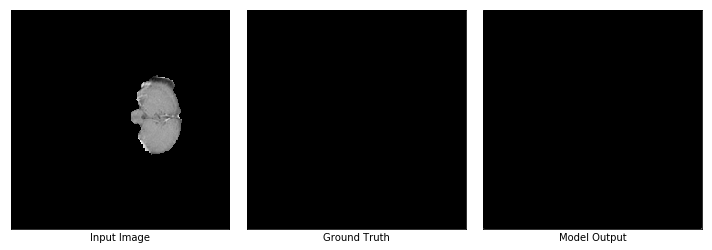

Steps: 5200, Loss:0.4685947895050049, Dice Coefficient: 0.5314052104949951
Gradient min:-0.11738137155771255, max:0.08776537328958511



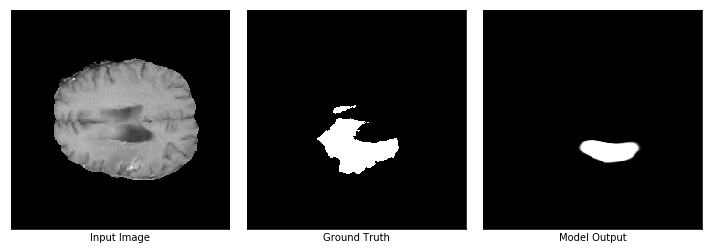

Steps: 5300, Loss:0.43619078397750854, Dice Coefficient: 0.5638092160224915
Gradient min:-0.13933774828910828, max:0.10543835908174515



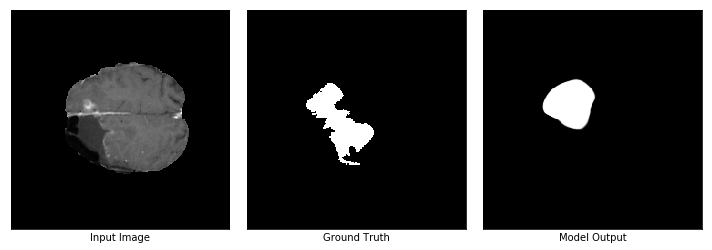

Steps: 5400, Loss:0.3584057092666626, Dice Coefficient: 0.6415942907333374
Gradient min:-0.11012972891330719, max:0.18240004777908325



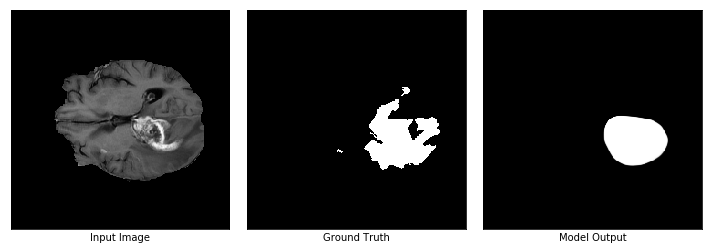

Steps: 5500, Loss:0.40931928157806396, Dice Coefficient: 0.590680718421936
Gradient min:-0.07237553596496582, max:0.11759457737207413



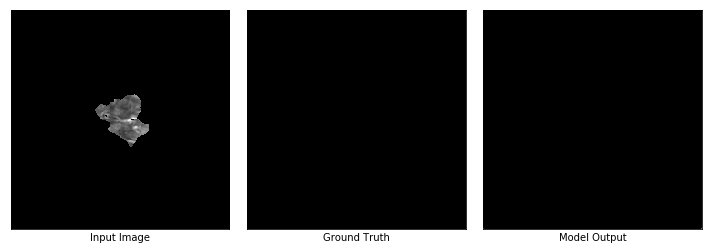

Steps: 5600, Loss:0.41247355937957764, Dice Coefficient: 0.5875264406204224
Gradient min:-0.10728747397661209, max:0.0891459658741951



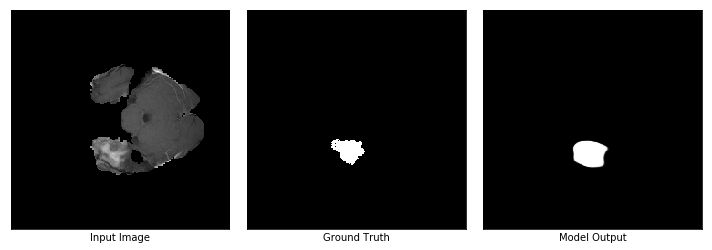

Steps: 5700, Loss:0.2197059988975525, Dice Coefficient: 0.7802940011024475
Gradient min:-0.03978358581662178, max:0.04879561811685562



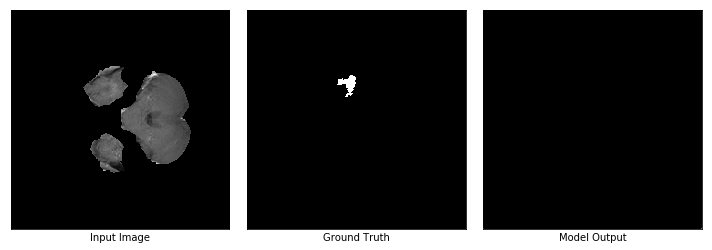

Steps: 5800, Loss:0.28394919633865356, Dice Coefficient: 0.7160508036613464
Gradient min:-0.06119302660226822, max:0.081649549305439



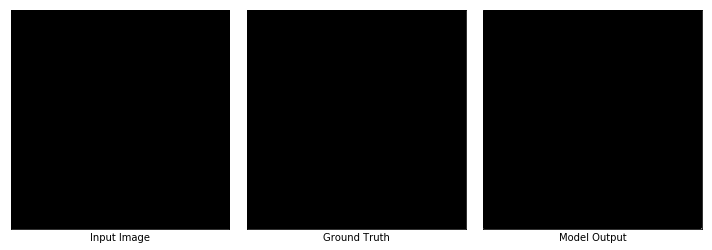

Steps: 5900, Loss:0.4253869652748108, Dice Coefficient: 0.5746130347251892
Gradient min:-0.06953233480453491, max:0.06993326544761658



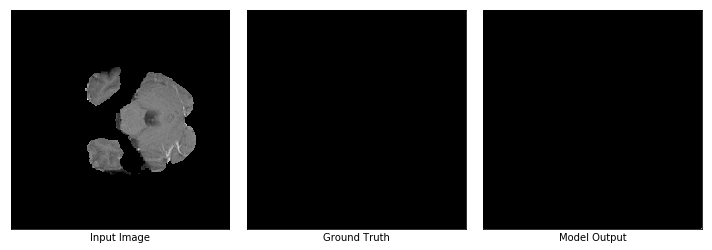

Steps: 6000, Loss:0.3616452217102051, Dice Coefficient: 0.6383547782897949
Gradient min:-0.15222254395484924, max:0.18016940355300903



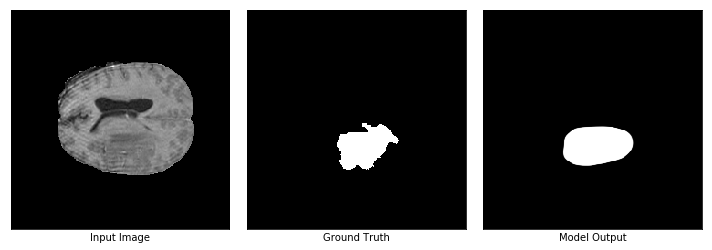

Steps: 6100, Loss:0.3201746344566345, Dice Coefficient: 0.6798253655433655
Gradient min:-0.14362400770187378, max:0.0943043977022171



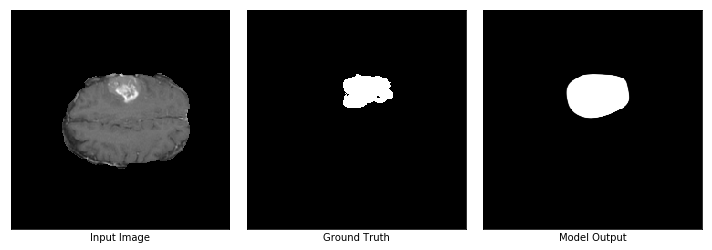

Steps: 6200, Loss:0.3016752600669861, Dice Coefficient: 0.6983247399330139
Gradient min:-0.11836223304271698, max:0.1346641629934311



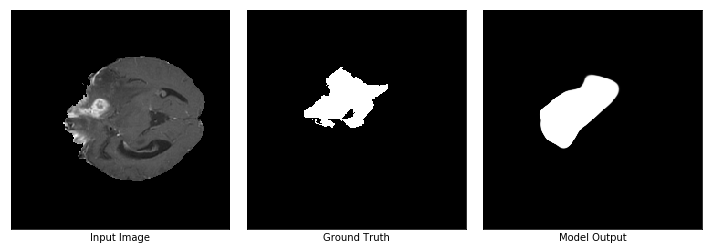

Steps: 6300, Loss:0.2441023588180542, Dice Coefficient: 0.7558976411819458
Gradient min:-0.019779058173298836, max:0.019761698320508003

Average Dice Coefficient: 0.5146565437316895
HGG_lbl_complete_tumor_HGG_training_MR_T2.tfrecords




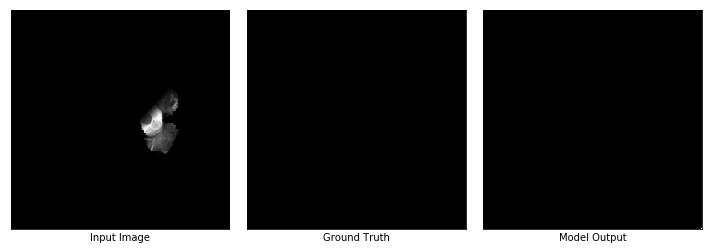

Steps: 6400, Loss:0.8219133019447327, Dice Coefficient: 0.17808669805526733
Gradient min:-0.06946711987257004, max:0.07221570611000061



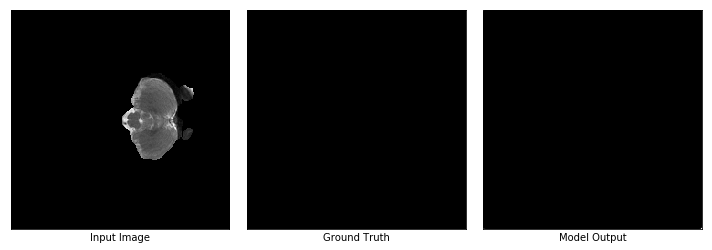

Steps: 6500, Loss:0.43434202671051025, Dice Coefficient: 0.5656579732894897
Gradient min:-0.2923199534416199, max:0.23748163878917694



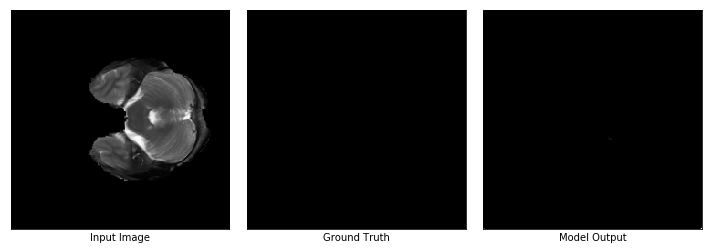

Steps: 6600, Loss:0.15534061193466187, Dice Coefficient: 0.8446593880653381
Gradient min:-0.09878524392843246, max:0.1207897737622261



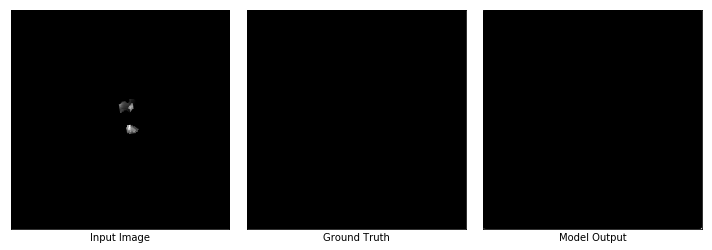

Steps: 6700, Loss:0.30168575048446655, Dice Coefficient: 0.6983142495155334
Gradient min:-0.07719526439905167, max:0.1283666342496872



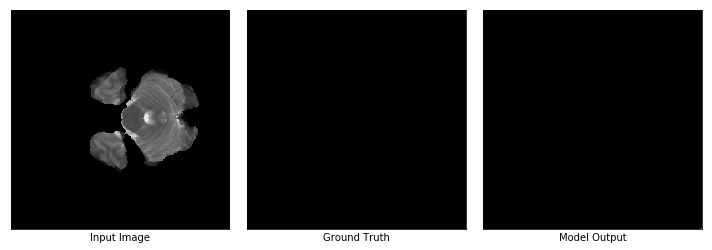

Steps: 6800, Loss:0.20962882041931152, Dice Coefficient: 0.7903711795806885
Gradient min:-0.09409312158823013, max:0.09448418766260147



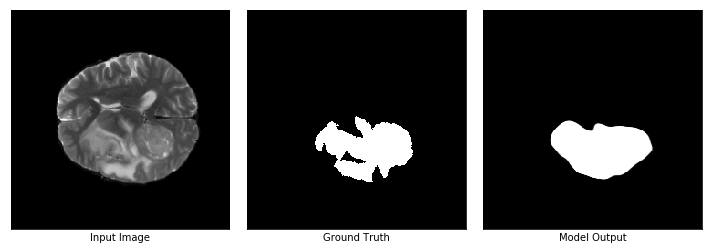

Steps: 6900, Loss:0.2021561861038208, Dice Coefficient: 0.7978438138961792
Gradient min:-0.06698785722255707, max:0.0416792631149292



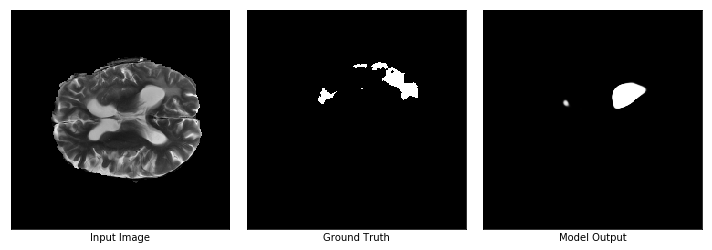

Steps: 7000, Loss:0.28417545557022095, Dice Coefficient: 0.715824544429779
Gradient min:-0.1526334136724472, max:0.18117213249206543



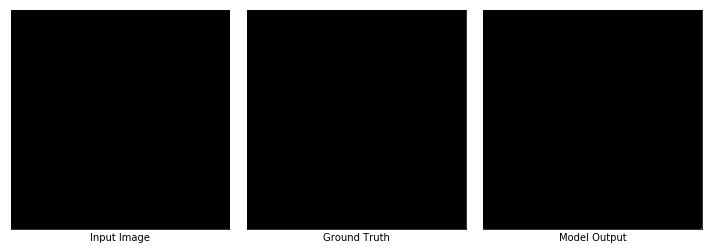

Steps: 7100, Loss:0.20993411540985107, Dice Coefficient: 0.7900658845901489
Gradient min:-0.23067322373390198, max:0.31406986713409424



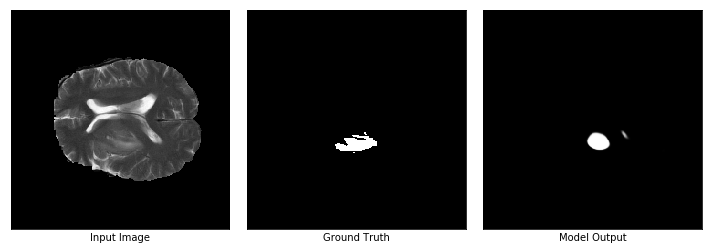

Steps: 7200, Loss:0.21444326639175415, Dice Coefficient: 0.7855567336082458
Gradient min:-0.08431561291217804, max:0.07323171943426132



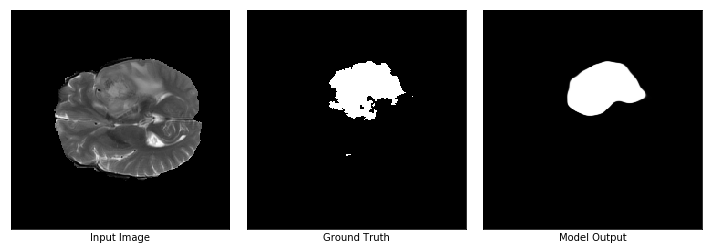

Steps: 7300, Loss:0.4069805145263672, Dice Coefficient: 0.5930194854736328
Gradient min:-0.20253345370292664, max:0.2753107249736786



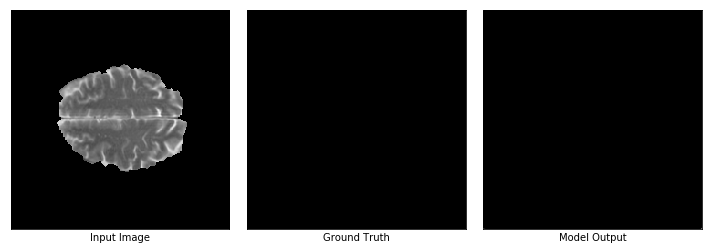

Steps: 7400, Loss:0.29361724853515625, Dice Coefficient: 0.7063827514648438
Gradient min:-0.11438381671905518, max:0.12301032245159149



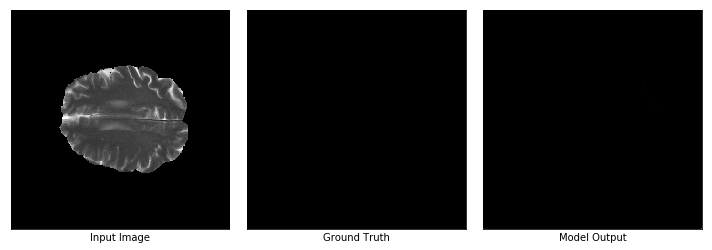

Steps: 7500, Loss:0.22156620025634766, Dice Coefficient: 0.7784337997436523
Gradient min:-0.1045522391796112, max:0.09119884669780731



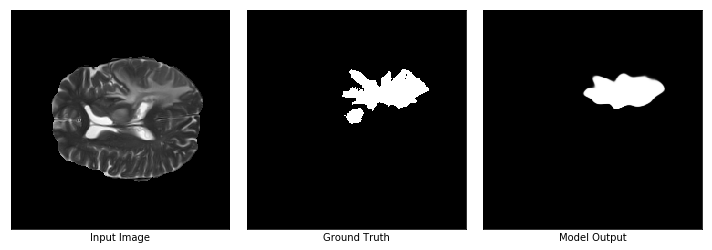

Steps: 7600, Loss:0.20813989639282227, Dice Coefficient: 0.7918601036071777
Gradient min:-0.1907830387353897, max:0.2543316185474396



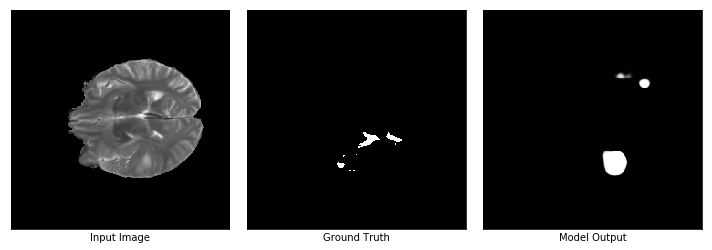

Steps: 7700, Loss:0.32740920782089233, Dice Coefficient: 0.6725907921791077
Gradient min:-1.2448279857635498, max:0.7843841314315796



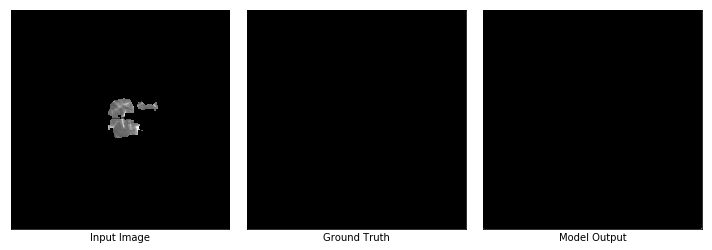

Steps: 7800, Loss:0.2479272484779358, Dice Coefficient: 0.7520727515220642
Gradient min:-0.06648996472358704, max:0.08263762295246124



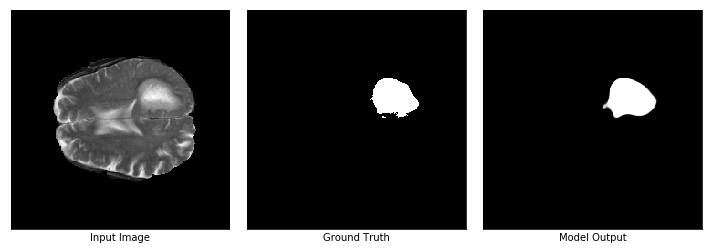

Steps: 7900, Loss:0.20289289951324463, Dice Coefficient: 0.7971071004867554
Gradient min:-0.11629676073789597, max:0.06637155264616013



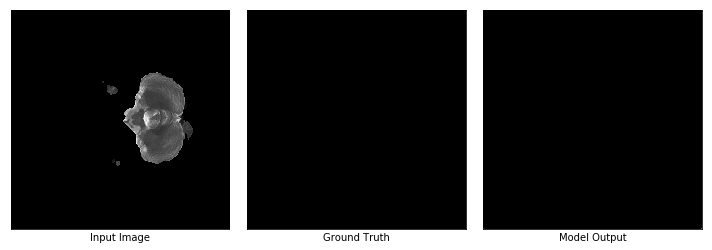

Steps: 8000, Loss:0.24279344081878662, Dice Coefficient: 0.7572065591812134
Gradient min:-0.16063301265239716, max:0.16480733454227448



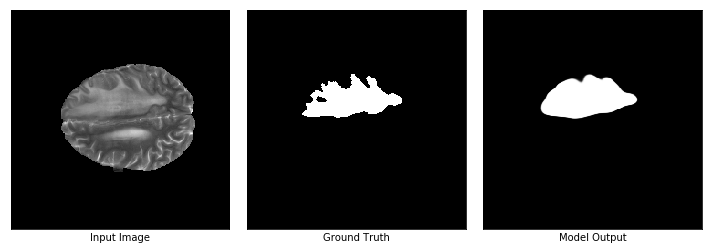

Steps: 8100, Loss:0.15628015995025635, Dice Coefficient: 0.8437198400497437
Gradient min:-0.10763618350028992, max:0.20370841026306152



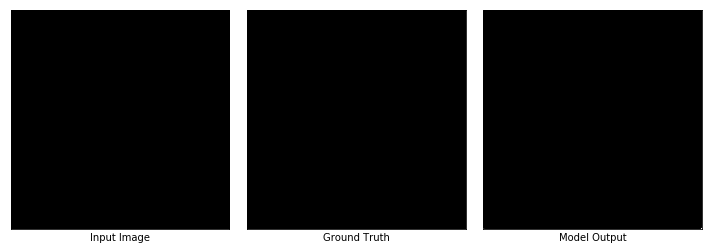

Steps: 8200, Loss:0.2225680947303772, Dice Coefficient: 0.7774319052696228
Gradient min:-0.08571679890155792, max:0.054504260420799255



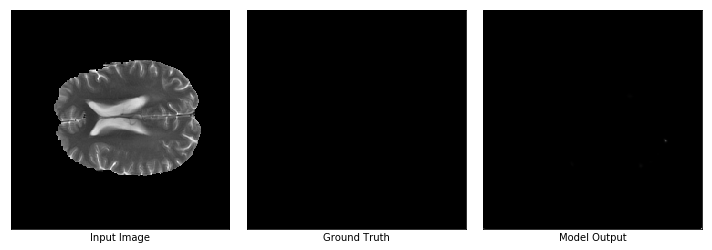

Steps: 8300, Loss:0.26619064807891846, Dice Coefficient: 0.7338093519210815
Gradient min:-0.36853474378585815, max:0.2975212633609772



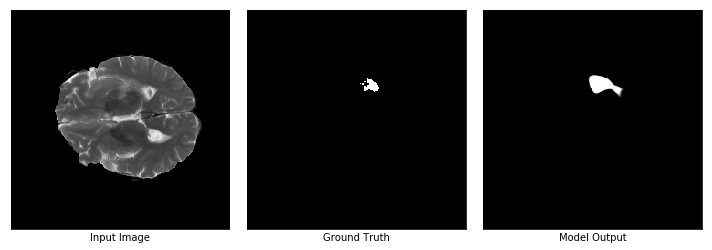

Steps: 8400, Loss:0.2802826166152954, Dice Coefficient: 0.7197173833847046
Gradient min:-0.23720945417881012, max:0.18205943703651428



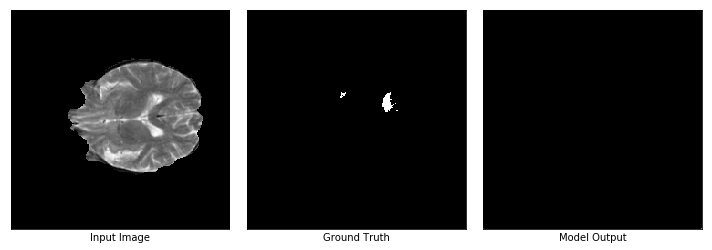

Steps: 8500, Loss:0.2314329743385315, Dice Coefficient: 0.7685670256614685
Gradient min:-0.31626904010772705, max:0.25660571455955505

Average Dice Coefficient: 0.5690157413482666


In [7]:
epochs = 1
max_epochs = 1
predicted_img = []
groundtruth_img = []
loss_list = []
dice_list = []
while epochs <= max_epochs:
    print("Epochs {:2d}".format(epochs))
    print()
    steps = 1
    for tf_re in sorted(os.listdir(tfrecords_read_dir)):
        print(tf_re)
        print()
        tf_dir = os.path.join(tfrecords_read_dir+tf_re)
        dataset = utils.parse_tfrecord(tf_dir).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
        for image, label in dataset:
            image = tf.reshape(image, [-1, 240, 240, 1]) #(batch_size, img_size, img_size, channel)
            label = tf.reshape(label, [-1, 240, 240, 1]) #(batch_size, img_size, img_size, channel)
            img_seg, loss, gradients = train_fn(image, label) #training function 
            dice_score = 1 - loss #calculate dice score 
            
            dice_list.append(dice_score) #append dice score for every every images
            
            #output
            if steps%100==0:
                input_img = [image[0], label[0], img_seg[0]]
                caption = ['Input Image', 'Ground Truth', 'Model Output']
                plot_comparison(input_img, caption, n_col = 3)
                
                predicted_img.append(img_seg[0])
                groundtruth_img.append(label[0])
                loss_list.append(loss)
                print("Steps: {}, Loss:{}, Dice Coefficient: {}".format(steps, loss, dice_score))
                print("Gradient min:{}, max:{}".format(np.min(gradients[0]), np.max(gradients[0])))
            steps+=1
        print()
        print("Average Dice Coefficient: {}".format(np.mean(np.array(dice_list))))
    epochs+=1 

---

# Model Summary

In [8]:
Unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 240, 240, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 240, 240, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 64) 36928       activation[0][0]                 
______________________________________________________________________________________________